In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import os
import random
import tensorflow as tf

from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split

# Load dataset

In [2]:
images_pos = os.listdir("dataset/train/images/pos/")
list_image_pos = []
for image in images_pos:
    list_image_pos.append(f"dataset/train/images/pos/{image}")
images_neg = os.listdir("dataset/train/images/neg/")
list_image_neg = []
for image in images_neg:
    list_image_neg.append(f"dataset/train/images/neg/{image}")
images = list_image_neg + list_image_pos
random.Random(20).shuffle(images)

files = os.listdir("dataset/train/labels_csv/")
labels = []
for file in files:
    labels.append(file[:-4])
    
df = pd.DataFrame(images, columns=["Image"])
df["label"] = df["Image"].apply(lambda x: 1 if x[25:-4] in labels else 0)
df

,Image,label
0,dataset/train/images/pos/taupincl_pos_005.jpg,1
1,dataset/train/images/pos/aschulst_pos_007.jpg,1
2,dataset/train/images/neg/jangthom_neg_005.jpg,0
3,dataset/train/images/pos/shiyujie_pos_003.jpg,1
4,dataset/train/images/neg/smakhlou_neg_006.jpg,0
...,...,...
770,dataset/train/images/pos/shiyujie_pos_001.jpg,1
771,dataset/train/images/neg/operezal_neg_002.jpg,0
772,dataset/train/images/neg/honhuhoa_neg_009.jpg,0
773,dataset/train/images/pos/smakhlou_pos_003.jpg,1


# Create train and test datasets

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df["Image"], df["label"], random_state=15)

In [4]:
X_train

239    dataset/train/images/pos/maxvaill_pos_006.jpg
593    dataset/train/images/neg/eambrois_neg_003.jpg
536    dataset/train/images/pos/ljeannea_pos_003.jpg
334    dataset/train/images/pos/sbenarro_pos_003.jpg
729    dataset/train/images/neg/shiyujie_neg_005.jpg
                           ...                      
156    dataset/train/images/pos/hoxuanvi_pos_007.jpg
384    dataset/train/images/pos/gralljea_pos_006.jpg
645    dataset/train/images/pos/cebertra_pos_003.jpg
757    dataset/train/images/pos/gralljea_pos_007.jpg
456    dataset/train/images/neg/bourimer_neg_014.jpg
Name: Image, Length: 581, dtype: object

# Split train dataset into train and validation dataset

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=15)

In [6]:
X_train

336    dataset/train/images/pos/bettonyo_pos_006.jpg
84     dataset/train/images/neg/honhuhoa_neg_013.jpg
659    dataset/train/images/neg/traquoch_neg_003.jpg
149    dataset/train/images/neg/eambrois_neg_013.jpg
381    dataset/train/images/neg/corodrig_neg_005.jpg
                           ...                      
30     dataset/train/images/pos/hlesobre_pos_010.jpg
209    dataset/train/images/pos/shiyujie_pos_006.jpg
447    dataset/train/images/pos/taupincl_pos_009.jpg
246    dataset/train/images/pos/hlesobre_pos_008.jpg
259    dataset/train/images/pos/hoxuanvi_pos_006.jpg
Name: Image, Length: 464, dtype: object

At the end of this part, we have a train dataset, a validation dataset and a test dataset

# Visualize one image

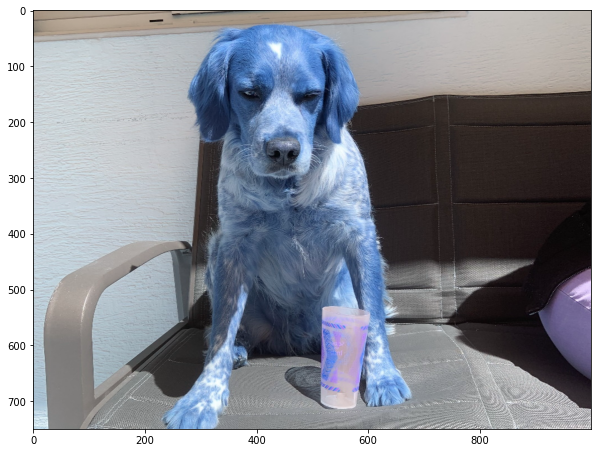

In [7]:
img = cv2.imread(X_train.iloc[0])
plt.figure(figsize=(10, 10))
plt.imshow(img)

## Add rectangle around ecocup

In [8]:
picture_name = X_train.iloc[0][25:-4]
labels = pd.read_csv(f"dataset/train/labels_csv/{picture_name}.csv", header=None)
labels.columns=["y", "x", "h", "w", "class"]
labels

,y,x,h,w,class
0,528,515,186,90,0


515


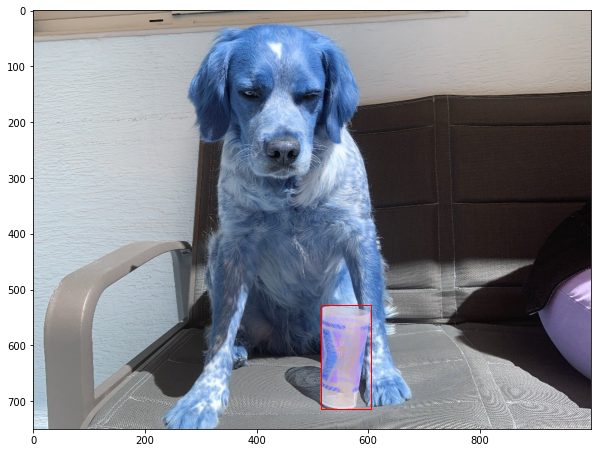

In [9]:
x = labels["x"][0]
y = labels["y"][0]
w = labels["w"][0]
h = labels["h"][0]

print(x)

figure, ax = plt.subplots(1, figsize=(10, 10))
rect = Rectangle((x,y),w,h, edgecolor='r', facecolor="none")
ax.imshow(img)
ax.add_patch(rect)
plt.show()

# Apply Selective Segmentation

In [10]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

ss.setBaseImage(img)

In [11]:
ss.switchToSelectiveSearchFast()
ssresults = ss.process()

In [12]:
ssresults.shape

(3431, 4)

## Define IoU

In [13]:
def get_IoU(box1, box2):
    """Return the Intersection over Union between 2 boxes

    Args:
        box1 (tuple): tuple containing x and y coordinates + width and height of the box 1
        box2 (tuple): tuple containing x and y coordinates + width and height of the box 2
    """

    x1_1 = box1[0]
    y1_1 = box1[1]
    x1_2 = x1_1 + box1[2]
    y1_2 = y1_1 + box1[3]

    x2_1 = box2[0]
    y2_1 = box2[1]
    x2_2 = x1_1 + box2[2]
    y2_2 = y1_1 + box2[3]

    x_1 = max(x1_1, x2_1)
    x_2 = min(x1_2, x2_2)
    y_1 = max(y1_1, y2_1)
    y_2 = min(y1_2, y2_2)

    intersection_area = max(0, x_2 - x_1) * max(0, y_2 - y_1)
    box1_area = (x1_2 - x1_1) * (y1_2 - y1_1)
    box2_area = (x2_2 - x2_1) * (y2_2 - y2_1)
    iou = intersection_area/(box1_area + box2_area - intersection_area)
    
    return iou

0.9562724014336917
0.8200716845878137
0.8758064516129033
0.8612903225806452
0.8825567502986857
0.9038231780167264
0.929868578255675
0.8621266427718041
0.9185711116041713
0.9041816009557945
0.8599735799207398
0.897431302270012
0.8104826469695436
0.8672985781990521
0.9131736526946108
0.9250896057347671
0.8825410360264336
0.8143355406156801


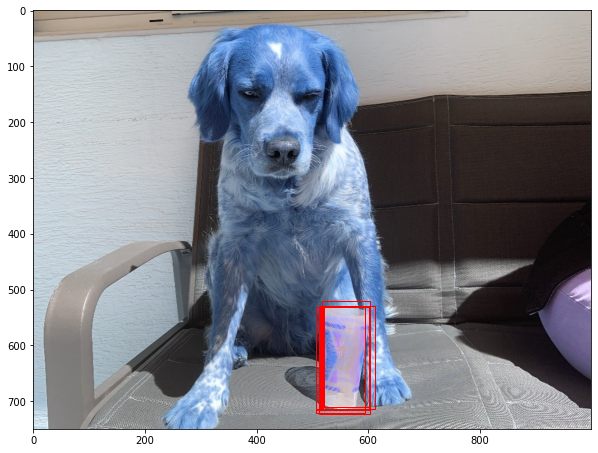

In [14]:
imOut = img.copy()
figure, ax = plt.subplots(1, figsize=(10, 10))

ax.imshow(img)
for i, rect in (enumerate(ssresults)):
    if i > 0:
        x_r, y_r, w_r, h_r = rect
        if get_IoU((x, y, w, h), (x_r, y_r, w_r, h_r)) >= 0.8:
            print(get_IoU((x, y, w, h), (x_r, y_r, w_r, h_r)))
            rect = Rectangle((x_r,y_r),w_r,h_r, edgecolor='r', facecolor="none")
            ax.add_patch(rect)
plt.show()

# Create function to have regions for training a Neural Network (VGG16)

In [15]:
positive_image = X_train[X_train.str.contains("pos")==True]
list(positive_image)

['dataset/train/images/pos/bettonyo_pos_006.jpg',
 'dataset/train/images/pos/amagnero_pos_007.jpg',
 'dataset/train/images/pos/gralljea_pos_007.jpg',
 'dataset/train/images/pos/hoxuanvi_pos_004.jpg',
 'dataset/train/images/pos/gralljea_pos_004.jpg',
 'dataset/train/images/pos/wahartlo_pos_005.jpg',
 'dataset/train/images/pos/hlesobre_pos_005.jpg',
 'dataset/train/images/pos/grallthi_pos_003.jpg',
 'dataset/train/images/pos/jchabbal_pos_005.jpg',
 'dataset/train/images/pos/maurinde_pos_005.jpg',
 'dataset/train/images/pos/durandoc_pos_003.jpg',
 'dataset/train/images/pos/smakhlou_pos_004.jpg',
 'dataset/train/images/pos/mparache_pos_005.jpg',
 'dataset/train/images/pos/operezal_pos_005.jpg',
 'dataset/train/images/pos/bettonyo_pos_013.jpg',
 'dataset/train/images/pos/eurinadr_pos_008.jpg',
 'dataset/train/images/pos/gralljea_pos_001.jpg',
 'dataset/train/images/pos/taupincl_pos_010.jpg',
 'dataset/train/images/pos/lelongph_pos_005.jpg',
 'dataset/train/images/pos/jchabbal_pos_009.jpg',


In [16]:
train_images = []
train_labels = []
nb_pos = 0
nb_viewed = 0
indice = 0
while nb_pos <= 3000:
    image = list(positive_image)[indice]
    img = cv2.imread(image)
    picture_name = image[25:-4]
    try:
        ecocup_locations = []
        labels = pd.read_csv(f"dataset/train/labels_csv/{picture_name}.csv", header=None)
        labels.columns=["y", "x", "h", "w", "class"]
        nb_viewed += 1
        print(nb_viewed, " File analyzed: ", picture_name)
        for label in labels.iterrows():
            x = labels["x"][0]
            y = labels["y"][0]
            w = labels["w"][0]
            h = labels["h"][0]
            ecocup_locations.append(
                {
                    "x": x,
                    "y": y,
                    "w": w,
                    "h": h
                }
            )
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e, result in enumerate(ssresults):
            for location in ecocup_locations:
                x = location["x"]
                y = location["y"]
                w = location["w"]
                h = location["h"]
                x_result, y_result, w_result, h_result = result
                iou = get_IoU(
                    (x, y, w, h),
                    (x_result, y_result, w_result, h_result)
                )
                if h_result > 0.05*imout.shape[0] and w_result > 0.05*imout.shape[1]:
                    if iou > 0.7:
                        train_image = imout[y_result:y_result+h_result, x_result:x_result+h_result]
                        resized = cv2.resize(train_image, (224,224), interpolation = cv2.INTER_AREA)
                        train_images.append(resized)
                        train_labels.append(1)
                        nb_pos += 1
                    elif iou < 0.2:
                        add = np.random.binomial(n=1, p= 0.007)
                        if add == 1:
                            train_image = imout[y_result:y_result+h_result, x_result:x_result+h_result]
                            resized = cv2.resize(train_image, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(0)
        print("Negative label: ", len(train_labels)-nb_pos, " --------------- Postive label: ", nb_pos)
    except Exception as exception:
        print(exception)
        print("error on file: ", picture_name)
    indice += 1


1  File analyzed:  bettonyo_pos_006
Negative label:  7  --------------- Postive label:  19
2  File analyzed:  amagnero_pos_007
Negative label:  18  --------------- Postive label:  38
3  File analyzed:  gralljea_pos_007
Negative label:  32  --------------- Postive label:  38
4  File analyzed:  hoxuanvi_pos_004
Negative label:  41  --------------- Postive label:  49
5  File analyzed:  gralljea_pos_004
Negative label:  44  --------------- Postive label:  49
6  File analyzed:  wahartlo_pos_005
Negative label:  54  --------------- Postive label:  55
7  File analyzed:  hlesobre_pos_005
Negative label:  65  --------------- Postive label:  56
8  File analyzed:  grallthi_pos_003
Negative label:  72  --------------- Postive label:  57
9  File analyzed:  jchabbal_pos_005
Negative label:  86  --------------- Postive label:  68
10  File analyzed:  maurinde_pos_005
Negative label:  95  --------------- Postive label:  79
11  File analyzed:  durandoc_pos_003
Negative label:  114  --------------- Posti

/var/folders/13/2bs52tzx5vb8jg2f094msm5h0000gn/T/ipykernel_19918/1656536753.py:27: RuntimeWarning: invalid value encountered in long_scalars
  iou = intersection_area/(box1_area + box2_area - intersection_area)


Negative label:  773  --------------- Postive label:  381
38  File analyzed:  eurinadr_pos_006
Negative label:  811  --------------- Postive label:  385
39  File analyzed:  saidmoha_pos_002
Negative label:  822  --------------- Postive label:  389
40  File analyzed:  lelongph_pos_001
Negative label:  843  --------------- Postive label:  391
41  File analyzed:  maxvaill_pos_010
Negative label:  857  --------------- Postive label:  391
42  File analyzed:  andrerom_pos_003
Negative label:  860  --------------- Postive label:  414
43  File analyzed:  olahnech_pos_002
Negative label:  877  --------------- Postive label:  414
44  File analyzed:  hoxuanvi_pos_002
Negative label:  888  --------------- Postive label:  433
45  File analyzed:  hlesobre_pos_006
Negative label:  899  --------------- Postive label:  433
46  File analyzed:  vivatben_pos_001
Negative label:  924  --------------- Postive label:  465
47  File analyzed:  detreear_pos_007
Negative label:  927  --------------- Postive labe

In [17]:
len(train_images)

7964

In [18]:
train_labels

[1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


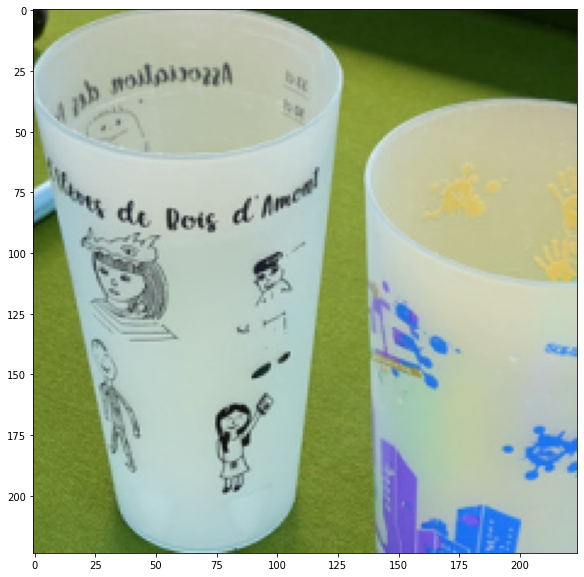

In [19]:
plt.figure(figsize=(10, 10))
plt.imshow(train_images[-5])
plt.show()

In [20]:
np.save("train_images", np.array(train_images))
np.save("train_labels", np.array(train_labels))

In [45]:
from sklearn.preprocessing import LabelBinarizer
class CustomLabelBinarizer(LabelBinarizer):
    def transform(self, labels):
        labels_transformed = super().transform(labels)
        return np.hstack([labels_transformed, 1-labels_transformed])

In [46]:
xx = CustomLabelBinarizer()
xxx = xx.fit_transform(train_labels)
xxx

array([[1, 0],
       [1, 0],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])